# This notebook 
## 1) reads and processes .mat files from Graf 2011
## 2) computes spike counts per trial
## 3) plots tuning curves
## 4) builds a Poisson Independent Decoder (PID)
## 5) builds an L1 regularized multinomial logistic regression model
## 6) builds a Bayesian hierarchical logistic regression model (many variations) 
## 7) evaluates the three models

In [1]:
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import *
from edward.models import Categorical, Empirical, Laplace,Bernoulli, Multinomial, Normal, PointMass, MultivariateNormalDiag, MultivariateNormalFullCovariance, MultivariateNormalTriL

/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [3]:
tf.__version__

'1.2.1'

In [4]:
ed.set_seed(42)

In [127]:
def read_data(file_path):
    '''Read and process mat file from Graf2011
    
    param array_number: {1, 2, 3, 4, 5}

    return:
        spike_times: {Nx3600} N simultaneously recorded spike trains for 3600 trials
            (50 repeated trials of 72 direction in random order)
        orientation_per_trial: orientation for each trial (of length 3600)
        num_neurons: number of neurons
        orientations: sorted set of orientations
        num_repeats: number of repeats for each (orientation,neuron) (=50)
        num_trials: 50 repeated trials x 72 directions
        trial_length: length of trial (in seconds)
    '''
    dataStruct = scipy.io.loadmat(file_path)
    spike_times = pd.DataFrame.from_dict(dataStruct['spk_times'])
    orientation_per_trial = dataStruct['ori'][0]
    num_neurons = np.shape(dataStruct['neur_param'])[0]
    orientations = np.sort(np.unique(dataStruct['ori']))
    trial_length = 2560e-3
    num_repeats = 50
    num_trials = 3600 # 50 repeated trials x 72 directions
    num_orientations = len(orientations)
    return spike_times, orientation_per_trial, num_neurons, orientations, trial_length, num_repeats, num_trials, num_orientations

In [128]:
def compute_spike_counts(spike_times, num_neurons, num_trials):
    '''
        Compute spike counts for each (orientation, neuron, trial)
        return 3D numpy array: orientation x trials x neurons
        
        TODO: add option to average [0 180] with responses from [180 360]
    '''
    spike_times_mat = spike_times.as_matrix()
    spike_counts = np.zeros((num_orientations, num_neurons, num_repeats))
    # for each orientation
    for i in range(num_orientations):
        # access indices in spike times that corresponds to ori
        idx = np.where(orientation_per_trial == orientations[i])[0]
        spike_times_ori = np.take(spike_times_mat, idx, axis = 1)
        for j in range(num_neurons):
            for k in range(num_repeats):
                spike_counts[i, j, k] = np.count_nonzero(spike_times_ori[j][k])
    return spike_counts

In [129]:
'''
Filters to data
1) spike counts observed after 1280 ms
    - exclude
    - use to filter neurons that do not have a significantly higher mean tc with stimulus than without

2) from paper, 
To get visually driven neurons, we only accepted neurons of which the
peak or trough of their tuning curve fell outside of the window defined
by the mean and one s.d. of their spontaneous activity. Furthermore, we
obtained meaningful sample of V1 neurons by only considering neurons with
tuning curves that could be well approximated (r2   0.75) by bimodal
circular Gaussian functions (the sum of two von Mises functions with
different preferred orientations, amplitudes and bandwidths), allowing us
to accommo- date for direction (mono-modal) or orientation (bi-modal)
tuning. We obtained populations of simultaneously recorded neurons of
sizes 40, 57, 60, 70 and 74. Each data set was obtained in a ~3-h-long
recording session.

3) average across 180 degree axis?

4) if max of tc for neuron i across orientations - min of tc for neuron i across orientations is 
    not greater than 10, -> exclude neuron
    
5) divisive normalization

'''

def normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats):
    '''
        Normalize by variance of spike counts
            for each trial
                square spike counts across (neurons, orientations) then sum across neurons
                divide the square of each spike count by the summed squared spike counts across neurons
                
        PROBLEM: mean tuning curve gives same mean for all entries
    '''
    spike_counts_norm = np.zeros((num_orientations, num_neurons, num_repeats))
    for i in range(num_repeats):
        variance_sum = np.sum(spike_counts[:, :, i]**2, axis = 1).reshape(-1,1)
        spike_counts_norm[:, :, i] = (spike_counts[:, :, i]**2) / np.tile(variance_sum, num_neurons)
    return spike_counts_norm

In [ ]:
best fit to the tuning curve 

one von mise might get too narrow - add a constraint to keep the means separate and prevent variances from going to 0

From Graf 2011, "Evoked activity was estimated over the full stimulus presentation. We neglected the contamination by the blank preceding each grating because this period of the response (the first ~60 ms corresponding to typical V1 response latencies50) was of negligible duration compared with the 1,280 ms stimulus presentation time and this contamination was the same for each grating. Spontaneous activity was assessed on the last 500 ms of each blank presentation to avoid contamina- tion induced by the preceding grating. To get visually driven neurons, we only accepted neurons of which the peak or trough of their tuning curve fell outside of the window defined by the mean and one s.d. of their spontaneous activity. Furthermore, we obtained meaningful sample of V1 neurons by only considering neurons with tuning curves that could be well approximated (r2   0.75) by bimodal circular Gaussian functions (the sum of two von Mises functions with different preferred orientations, amplitudes and bandwidths), allowing us to accommo- date for direction (mono-modal) or orientation (bi-modal) tuning."



From Montijn 2014, "To further parameterize neuronal orientation tuning, we also calculated each neuron's preferred direction by fitting a double von Mises distribution to the neuron's responses, where the peaks of both von Mises functions are opposite to each other (separated by 180°):

$$f(x∣∣θ,κ1,κ2,μ0)= \frac{e^{κ_1cos(x−θ)}}{2πI_0(κ_1)} + \frac{e^{κ_2cos(x+π−θ)}}{2πI_0(κ_2)}+μ_0$$
(1)
Here, I0(κ) is the modified Bessel function of order 0 and x represents the stimulus angle. As can be seen in the equation, we defined the free parameters as θ (preferred direction), κ1 (concentration parameter at θ), κ2 (concentration parameter at θ +π) and μ0 (baseline response). A neuron's preferred direction was defined as the angle with the highest concentration parameter (which could be either κ1 or κ2)."

## is this based on training data or all?

In [130]:
def compute_mean_tc(spike_counts):
    return np.mean(spike_counts, axis=2)

def compute_var_tc(spike_counts):
    return np.var(spike_counts, axis=2)

def compute_cov_tc(spike_counts):
    tc_cov = np.zeros((num_neurons, num_neurons, num_orientations))
    for i in range(num_orientations):
        tc_cov[:, :, i] = np.cov(spike_counts[i])
    return tc_cov

In [131]:
def compute_preferred_orientation(mean_tc, num_neurons):
    '''max of tuning curve across orientations'''
    pref_ori = np.zeros(147)
    for i in range(num_neurons):
        pref_ori[i] = np.argmax(mean_tc[:,i])
    return pref_ori

In [132]:
plt.plot(pref_ori)

NameError: name 'pref_ori' is not defined

In [133]:
def filter_to_well_tuned_neurons(mean_tc, thresh):
    '''Filter to well tuned neurons, example thresh = 10'''
    maxdiff = np.max(mean_tc, axis=0) - np.min(mean_tc, axis=0)
    ind_tuned = np.where(maxdiff > thresh)[0]
    return ind_tuned

In [134]:
# path to mat file from Graf 2011
file_path = '../../data/graf_V1data/array_2.mat'

# read and process data
spike_times, orientation_per_trial, num_neurons, orientations, trial_length,\
    num_repeats, num_trials, num_orientations = read_data(file_path)

# compute spike counts
spike_counts = compute_spike_counts(spike_times, num_neurons, num_trials)

# compute tuning curves
mean_tc = compute_mean_tc(spike_counts)
var_tc = compute_var_tc(spike_counts)
cov_tc = compute_cov_tc(spike_counts)

# identify indices for well-tuned neurons
ind_well_tuned = filter_to_well_tuned_neurons(mean_tc, 10)

# normalize spike counts
spike_counts_norm = normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats)

# compute normalized tuning curves
mean_tc_norm = compute_mean_tc(spike_counts_norm)
var_tc_norm = compute_var_tc(spike_counts_norm)
cov_tc_norm = compute_cov_tc(spike_counts_norm)

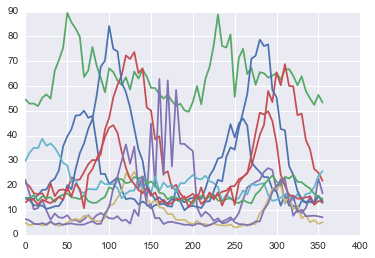

In [60]:
# plot mean tuning curve for 10 well tuned neurons
%matplotlib inline
sns.set_style("darkgrid")
plt.plot(orientations, mean_tc[:, ind_well_tuned[0:10]]);

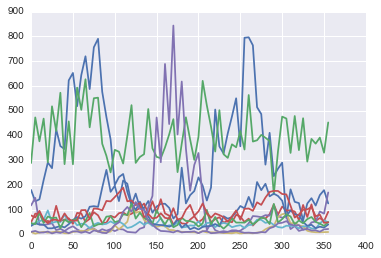

In [61]:
# plot variance tuning curve for 10 well tuned neurons
plt.plot(orientations, var_tc[:, ind_well_tuned[0:10]]);

## EVALUATION METRICS
1) Figure 4 from Graf '11 measuring orientation discrimination accuracy.
Compute likelihood ratio tests between $\theta$ and $\theta + \delta \theta$ where $\delta = \in \{5, 10, 15, 20, 25, 30\}$ across all 72 values of $\theta$. So train each model on 35 samples and test on 15 for each class.

In [135]:
def likelihood_ratio_test(likelihood_one, likelihood_two):
    diff = likelihood_one - likelihood_two
    diff[diff > 0] = 1
    diff[diff < 0] = 2
    return diff

def likelihood(w_i, r_i, b_i):
    '''Compute data likelihood given w, r, b for stimulus i'''
    #return np.log(np.sum(np.dot(w_i, r_i.T)) + b_i)
    return np.log(np.dot(w_i, r_i.T) + b_i)
    

def evaluate_model(x_test, w, b):    
    probabilities = np.zeros((72, 6)) # orientations x deltas
    deltas = [1, 2, 3, 4, 5, 6]
    # for each ori
    for i in range(72):
        # for each delta
        for delta in deltas:
            test_data = (np.concatenate((x_test[i], x_test[(i+delta) % 72])))
            test_labels = np.repeat(np.arange(1,3), 15)
            likelihoods_one = likelihood(w[i], test_data, b[i])
            likelihoods_two = likelihood(w[(i+delta) % 72], test_data, b[(i+delta) % 72])
            pred_labels = likelihood_ratio_test(likelihoods_one, likelihoods_two)
            probabilities[i][delta-1] = sklearn.metrics.accuracy_score(pred_labels, test_labels)
    return np.mean(probabilities, axis=0)

In [136]:
def multiclass_log_likelihood(c, w, x, b):
    logit = np.dot(w[c], x.T) + b[c]
    numerator = np.exp(logit)
    denominator = 0
    C = 72
    for i in range(C):
        denominator = denominator + np.exp(np.dot(w[i], x.T) + b[i])
    return np.log(numerator / denominator)

def evaluate_multiclass_model(x, w, b):    
    deltas = [1, 2, 3, 4, 5, 6]
    C = 72
    probabilities = np.zeros((C, len(deltas))) # orientations x deltas

    # for each ori
    for i in range(C):
        # for each delta
        for delta in deltas:
            test_data = (np.concatenate((x[i], x[(i+delta) % C])))
            test_labels = np.repeat(np.arange(1,3), 15)
            likelihoods_one = multiclass_log_likelihood(i, w, test_data, b)
            likelihoods_two = multiclass_log_likelihood((i+delta)%C, w, test_data, b)
            pred_labels = likelihood_ratio_test(likelihoods_one, likelihoods_two)
            
            probabilities[i][delta-1] = sklearn.metrics.accuracy_score(pred_labels.astype(int), test_labels)
    return np.mean(probabilities, axis=0)

In [ ]:
# green is sklearn l1
# blue is with Stan normal(0,1) prior
# yellow is VI with sample covariance prior
# brown is edward normal(0, .1) prior
# red is PID

xticks = [5, 10, 15, 20, 25, 30]
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, w_model.T, b_model))
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, beta, intercept))
#plt.plot(xticks,evaluate_multiclass_model(x_test_scaled, lr.coef_, lr.intercept_))
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, beta_ori, intercept_ori))
#plt.plevaluate_multiclass_model(x_test_scaled, qw_mod.eval().T, qb_mod.eval())

plt.plot(xticks, evaluate_model(x_test_scaled, w, b))
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, w_vi.T, b_vi))

#plt.plot(xticks,evaluate_multiclass_model(x_test_scaled, qw_mod.eval().T, qb_mod.eval()))
plt.plot(xticks,([ 0.91157407,  0.94722222,  0.97685185,  0.98842593,  0.99583333,
        0.99768519]))
plt.plot(xticks,([ 0.92037037,  0.96435185,  0.98148148,  0.9912037 ,  0.99768519,
        0.99722222]))

#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, qw_mod.eval().T, qb_mod.eval()))

plt.ylabel("probability correct")
plt.xlabel("orientation difference (degrees)")

### Lets build a Poisson Independent Decoder (PID). We assume each neuron's stimulus-specific spike counts is Poisson distributed and statistically independent across neurons. The rate parameter $w_i(\theta)$ is the logarithm of the mean neuronal tuning function for neuron i across trials for stimulus $\theta$.

### The likelihood function is $\log L(\theta) = \sum_{i=1}^N w_i(\theta)r_i + b(\theta)$. The offset b incorporates overall bias in coverage of orientations and is the sum of the mean tuning curve across neurons for stimulus $\theta$.

In [16]:
def compute_mean_tc_training(x):
    '''compute mean tuning curve (mean of samples for a given orientation,neuron) given training data (orientation,samples) x neurons'''
    mean_tc = np.zeros((x.shape[0], x.shape[2]))
    for i in range(72):
        mean_tc[i] = np.mean(x[i], axis = 0)
    return mean_tc

In [137]:
# filter to well-tuned neurons then rotate axes so we have ori x samples x neurons
spike_counts_filt = np.rollaxis(np.rollaxis(spike_counts[:, ind_well_tuned, :], 2), 1)
# train/test split
inds = np.arange(50)
train_ind = np.random.choice(inds, size = 35, replace = False)
test_ind =  np.array([x for x in inds if x not in train_ind])
x_train, x_test = spike_counts_filt[:, train_ind, :], spike_counts_filt[:, test_ind, :]
# compute mean training curve on training data
mean_tc_train = compute_mean_tc_training(x_train)
# weights are log of mean tuning curve
w = np.log(mean_tc_train)
b = np.sum(w, axis=1)

In [50]:
def likelihood_(w_i, r_i, b_i):
    '''Compute data likelihood given w, r, b for stimulus i'''
    return np.log(np.sum(np.dot(w_i, r_i.T)) + b_i)

In [51]:
def plot_likelihood(w, x_train, b, stimulus_choice):
    '''plot likelihood of stimulus-specific spike train as a function of model choice'''
    sx = []
    for i in range(72):
        sx.append(likelihood(w[i], x_train[stimulus_choice], b[i]))
    fig = plt.plot(sx)

In [52]:
def likelihood_ratio_test_(w, x_train, b, ori1, ori2):
    '''given a population response, compute likelihood ratio test comparing two orientation models'''
    val = likelihood(w[ori1], x_train, b[ori1]) - likelihood(w[ori2], x_train, b[ori2])
    if val > 0:
        return ori1
    else:
        return ori2

In [53]:
likelihood_ratio_test(w, x_train[10], b, 45,10)

TypeError: likelihood_ratio_test() takes 2 positional arguments but 5 were given

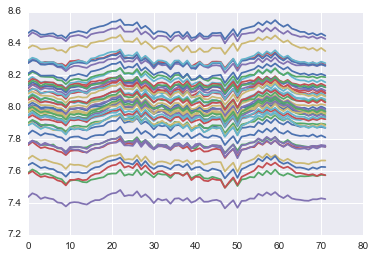

In [54]:
# likelihood comparison -- which model provides best explanation of the data?,
plot_likelihood(w, x_train, b, 1) # for example, we fit spike trains from ori 1 against all possible models
plot_likelihood(w, x_test, b, 1)

## DATA Processing 

In [140]:
### DATA PROCESSING
Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
Xtest = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])

Ytrain = np.repeat(np.arange(72), x_train.shape[1])
Ytest = np.repeat(np.arange(72), x_test.shape[1])


C = 72
N,D = Xtrain.shape[0], Xtrain.shape[1]

Xtrain_scaled = sklearn.preprocessing.scale(Xtrain)
Xtest_scaled = sklearn.preprocessing.scale(Xtest)
Ytrain_hot = tf.one_hot(Ytrain, depth=C).eval()
Ytest_hot = tf.one_hot(Ytest, depth=C).eval()

x_test_scaled_3d = np.zeros((72,15,58))
for i in range(72):
    x_test_scaled_3d[i] = Xtest_scaled[i*15:i*15+15]

### Lets build a L1 regularized multinomial multi-class logistic regression model

In [141]:
# specify model
lr = sklearn.linear_model.LogisticRegression(penalty='l1', fit_intercept=True)

# fit the model
lr.fit(Xtrain_scaled, np.repeat(np.arange(72),35))

## predict labels and probability distributions on test data
#labels_test = lr.predict(sklearn.preprocessing.scale(Xtest_scaled))
#scores_test = lr.predict_proba(sklearn.preprocessing.scale(Xtest_scaled))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [143]:
evaluate_multiclass_model(x_test_scaled_3d, lr.coef_, lr.intercept_)

array([ 0.74259259,  0.78981481,  0.89166667,  0.94398148,  0.96990741,
        0.97962963])

In [144]:
def evaluate_one_versus_all(y_test, scores):
    '''AUC scores for one versus all classification on test data across all classes'''
    aucs = []
    for j in range(72):
        sx = []
        for i in range(len(y_test)):
            if y_test[i] == (j+1):
                sx.append(int(1))
            else:
                sx.append(int(0))
        aucs.append(sklearn.metrics.roc_auc_score(np.array(sx),scores[:,j]))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

In [145]:
def evaluate_one_versus_one(y_test, scores, delta):
    '''AUC scores for one class versus one class on test data across all classes
        delta, int : discriminate between class and class + delta    
    '''
    aucs = []
    for j in range(1,73):
        inds = np.concatenate((np.where(y_test == (j))[0], np.where(y_test == (((j-1)+delta) % 72) + 1)[0]))
        #print(y_test[inds])
        #print(scores[inds,j-1])
        y = (y_test[inds] == j).astype(int)
        aucs.append((sklearn.metrics.roc_auc_score(y, scores[inds,j-1])))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

In [ ]:
evaluate_one_versus_one(y_test, scores_test, 1)
evaluate_one_versus_one(y_test, scores_test, 2)
evaluate_one_versus_one(y_test, scores_test, 5)
evaluate_one_versus_one(y_test, scores_test, 10)
evaluate_one_versus_one(y_test, scores_test, 20)

## Takeaway: model does poorly at discriminating between small deltas.

### Lets build a Bayesian multinomial multi-class logistic regression model
$$p(\theta^{(i)} = c | r^{(i)}, w^{(c)}) = \frac{\exp{(w^{(c)T}r^{(i)})}}{\sum_{j=1}^C(w^{(j)T}r^{(i)})}$$
$$p(w^{(c)}|\Lambda^{(c)}) = \mathcal{N}(0, \Lambda^{(c)}), \Lambda^{(c)} \in \mathcal{R^{\text{NxN}}}$$

## Set variance across neurons; MAP estimation; two class setting
$$p(y | x, w)$$
$$p(w | 0, \sigma I)$$

In [120]:
def compute_average_auc(predictions, labels):
    classes = labels.shape[1]
    aucs = np.zeros((classes))
    for i in range(classes):
        aucs[i] = sklearn.metrics.roc_auc_score(labels[:,i], predictions[:,i])
    return np.mean(aucs)

In [ ]:
sess = ed.get_session()

# 1) w ~ N(0,1) with MAP

In [148]:
C = 72
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc = tf.zeros([D,C-1]), scale = 1 * tf.ones([C-1]))
b = Normal(loc= tf.zeros(C-1), scale = 1.0 * tf.ones(C-1))
logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(probs = tf.nn.softmax(logits))

# INFERENCE
qw_loc = tf.Variable(tf.zeros([D,C-1]))
qb_loc = tf.Variable(tf.zeros([C-1]))

qw = PointMass(params = qw_loc)
qb = PointMass(params = qb_loc)

inference = ed.MAP({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.run()

# EVAL
qw_mod = tf.concat([qw.mean(), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 5992.511
0.977373500261
[ 0.74027778  0.81759259  0.92407407  0.96342593  0.98888889  0.99305556]


# 2) w ~ N(0, $\Lambda^{-1}$) with MAP and lambda1 = 1

In [382]:
# COVARIANCE MATRIX
A = np.zeros((C-1,C))
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .1 * np.identity(C) # A^T.dot(A) + .1 * I for invertability
lambda_1 = 1
precision = lambda_1 * precision
#precision = precision  + 1 * np.identity(C)
cov_matrix = np.linalg.inv(precision)
cov_matrix_chol = tf.cholesky(cov_matrix)

ValueError: shapes (72,71,58) and (58,71,72) not aligned: 58 (dim 2) != 71 (dim 1)

In [383]:
cov_matrix.shape

(72, 72)

In [385]:
cov_new = np.zeros((D, C-1, C-1))
for d in range(D):
    cov_new[d] = cov_matrix[:-1,:-1]

In [388]:
cov_new[1]

array([[  2.70156212e+00,   1.97171833e+00,   1.43904638e+00, ...,
          1.50207962e-09,   1.19183786e-09,   1.00077988e-09],
       [  1.97171833e+00,   2.16889016e+00,   1.58295101e+00, ...,
          1.65228758e-09,   1.31102164e-09,   1.10085787e-09],
       [  1.43904638e+00,   1.58295101e+00,   1.88515075e+00, ...,
          1.96772430e-09,   1.56130759e-09,   1.31102164e-09],
       ..., 
       [  1.50207962e-09,   1.65228758e-09,   1.96772430e-09, ...,
          1.73401072e+00,   1.37586557e+00,   1.15530696e+00],
       [  1.19183786e-09,   1.31102164e-09,   1.56130759e-09, ...,
          1.37586557e+00,   1.88515075e+00,   1.58295101e+00],
       [  1.00077988e-09,   1.10085787e-09,   1.31102164e-09, ...,
          1.15530696e+00,   1.58295101e+00,   2.16889016e+00]])

In [154]:
C = 72
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = MultivariateNormalTriL(loc = tf.zeros([D,C-1]), scale_tril = tf.cast(cov_matrix_chol[:-1,:-1], tf.float32))
b = Normal(loc= tf.zeros(C-1), scale = 1.0 * tf.ones(C-1))
logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(probs = tf.nn.softmax(logits))

# INFERENCE
qw_loc = tf.Variable(tf.zeros([D,C-1]))
qb_loc = tf.Variable(tf.zeros([C-1]))

qw = PointMass(params = qw_loc)
qb = PointMass(params = qb_loc)

inference = ed.MAP({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.run()

# EVAL
qw_mod = tf.concat([qw.mean(), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))


1000/1000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 5021.923
0.984804816554
[ 0.7712963   0.87453704  0.95462963  0.98101852  0.99212963  0.99675926]


In [160]:
tf.exp(tf.Variable(tf.zeros[10]))

TypeError: 'function' object is not subscriptable

In [336]:
tf.cholesky(.1*np.identity(D) + tf.ones((D,D))).eval()

array([[ 1.04880881,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9534626 ,  0.43693143,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9534626 ,  0.20806254,  0.38421226, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.9534626 ,  0.20806254,  0.12393942, ...,  0.31908447,
         0.        ,  0.        ],
       [ 0.9534626 ,  0.20806254,  0.12393942, ...,  0.00568778,
         0.31903377,  0.        ],
       [ 0.9534626 ,  0.20806254,  0.12393942, ...,  0.00568778,
         0.00558728,  0.31898484]], dtype=float32)

# 3) Lets now replicate 1) with variational inference instead of MAP
# starting with binary classification...

In [337]:
# DATA
Ytrain_bin = Ytrain[0:70]
Xtrain_bin = Xtrain_scaled[0:70]
Ytest_bin = Ytest[0:30]
Xtest_bin = Xtest_scaled[0:30]

sess = ed.get_session()

N, D = Xtrain_bin.shape[0], Xtrain_bin.shape[1]

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = MultivariateNormalFullCovariance(loc = tf.zeros(D), covariance_matrix = .1*np.identity(D) + 1 * tf.ones((D,D)))
b = Normal(loc = tf.zeros([]), scale = 1.0 * tf.ones([]))

y = Bernoulli(logits = ed.dot(X, w) + b)

# compare inference methods
'''
# MAP estimation
qw_loc = tf.Variable(tf.zeros([D]))
qb_loc = tf.Variable(tf.zeros([]))

qw = PointMass(params = qw_loc)
qb = PointMass(params = qb_loc)

inference = ed.MAP({w: qw, b: qb}, data={X: Xtrain_bin, y: Ytrain_bin})
inference.run()

# EVAL
y_preds = tf.sigmoid(ed.dot(tf.cast(Xtest_bin, tf.float32), qw.mean()) + qb.mean()).eval()
print(sklearn.metrics.roc_auc_score(Ytest_bin, y_preds))
'''

# VI
qw_loc = tf.Variable(tf.random_normal([D]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D])))


qb_loc = tf.Variable(tf.random_normal([]) + 10)
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc=qw_loc, scale=qw_scale)
qb = Normal(loc=qb_loc, scale=qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_bin, y: Ytrain_bin})
inference.initialize(n_samples=5, n_iter = 10000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

# EVAL
y_preds = tf.sigmoid(ed.dot(tf.cast(Xtest_bin, tf.float32), qw.mean()) + qb.mean()).eval()
print(sklearn.metrics.roc_auc_score(Ytest_bin, y_preds))

{'loss': 1141.4717, 't': 1}
{'loss': 60.790092, 't': 1001}
{'loss': 55.615585, 't': 2001}
{'loss': 56.857479, 't': 3001}
{'loss': 61.98587, 't': 4001}
{'loss': 56.89679, 't': 5001}
{'loss': 57.031734, 't': 6001}
{'loss': 52.859249, 't': 7001}
{'loss': 56.449089, 't': 8001}
{'loss': 52.592323, 't': 9001}
0.751111111111


# w ~ N(0, $\Lambda^{-1}$) with set precision, lambda1 =1, w is estimated with VI...the VI estimate of w is consistent with MAP

In [393]:
# DATA
sess = ed.get_session()
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = MultivariateNormalFullCovariance(loc = tf.zeros([D,C-1]), covariance_matrix = tf.cast(cov_new, tf.float32))

b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))

logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

# INFERENCE
qw_loc = tf.Variable(tf.random_normal([D, C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 5000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

{'loss': 72943.992, 't': 1}
{'loss': 9015.2402, 't': 101}
{'loss': 7741.7935, 't': 201}
{'loss': 7348.0776, 't': 301}
{'loss': 7190.6953, 't': 401}
{'loss': 7179.3286, 't': 501}
{'loss': 7031.6968, 't': 601}
{'loss': 7137.958, 't': 701}
{'loss': 7012.1758, 't': 801}
{'loss': 6830.0391, 't': 901}
{'loss': 7290.5972, 't': 1001}
{'loss': 7138.2407, 't': 1101}
{'loss': 6734.3799, 't': 1201}
{'loss': 6756.1211, 't': 1301}
{'loss': 6611.3853, 't': 1401}
{'loss': 6841.4785, 't': 1501}
{'loss': 6775.5591, 't': 1601}
{'loss': 6635.9727, 't': 1701}
{'loss': 6738.7559, 't': 1801}
{'loss': 6692.2139, 't': 1901}
{'loss': 6707.7861, 't': 2001}
{'loss': 6562.0869, 't': 2101}
{'loss': 6606.2642, 't': 2201}
{'loss': 6529.9541, 't': 2301}
{'loss': 6675.0635, 't': 2401}
{'loss': 6535.1489, 't': 2501}
{'loss': 6562.7139, 't': 2601}
{'loss': 6488.5825, 't': 2701}
{'loss': 6486.1611, 't': 2801}
{'loss': 6491.7271, 't': 2901}
{'loss': 6340.8477, 't': 3001}
{'loss': 6637.7915, 't': 3101}
{'loss': 6533.4561, '

# Now, lets optimize over our precision matrix

In [ ]:
# COVARIANCE MATRIX
A = np.zeros((C-1,C))
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .1 * np.identity(C) # A^T.dot(A) + .1 * I for invertability
lambda_1 = 1
precision = lambda_1 * precision
#precision = precision  + 1 * np.identity(C)
cov_matrix = np.linalg.inv(precision)
cov_matrix_chol = tf.cholesky(cov_matrix)

cov_new = np.zeros((D, C-1, C-1))
for d in range(D):
    cov_new[d] = cov_matrix[:-1,:-1]

In [ ]:
tf.Variable()

In [398]:
tf.matrix_inverse(cov_new)

<tf.Tensor 'MatrixInverse:0' shape=(58, 71, 71) dtype=float64>

In [420]:
# Design precision matrix
A = np.zeros((C-1,C))
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .1 * np.identity(C) # A^T.dot(A) + .1 * I for invertability
tau = tf.nn.softplus(tf.Variable(tf.random_normal([])))
#tau = 1
precision = tau * precision
cov = tf.matrix_inverse(precision)[:-1,:-1]

In [422]:
tf.tile(tf.expand_dims(cov, 0), [D, 1, 1])

<tf.Tensor 'Tile_11:0' shape=(58, 71, 71) dtype=float32>

In [423]:
cov_new.shape

TensorShape([Dimension(1)])

In [429]:
# DATA
sess = ed.get_session()
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

# MODEL
X = tf.placeholder(tf.float32, [N, D])

# Design precision matrix
A = np.zeros((C-1,C))
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .1 * np.identity(C) # A^T.dot(A) + .1 * I to create full rank
tau = tf.nn.softplus(tf.Variable(tf.random_normal([])))
precision = tau * precision
cov = tf.matrix_inverse(precision)[:-1,:-1]

w_cov = tf.tile(tf.expand_dims(cov, 0), [D, 1, 1])

w = MultivariateNormalFullCovariance(loc = tf.zeros([D,C-1]), covariance_matrix = tf.cast(w_cov, tf.float32))

b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))

logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

# INFERENCE
qw_loc = tf.Variable(tf.random_normal([D, C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 2000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

{'loss': 70619.609, 't': 1}
{'loss': 8964.6123, 't': 101}
{'loss': 7735.5547, 't': 201}
{'loss': 7610.1289, 't': 301}
{'loss': 7058.1636, 't': 401}
{'loss': 7147.731, 't': 501}
{'loss': 6754.022, 't': 601}
{'loss': 6656.0073, 't': 701}
{'loss': 6417.0278, 't': 801}
{'loss': 6754.9224, 't': 901}
{'loss': 6468.0737, 't': 1001}
{'loss': 6256.2847, 't': 1101}
{'loss': 6463.6328, 't': 1201}
{'loss': 6484.6147, 't': 1301}
{'loss': 6534.3003, 't': 1401}
{'loss': 6291.769, 't': 1501}
{'loss': 6283.0654, 't': 1601}
{'loss': 6086.3086, 't': 1701}
{'loss': 6056.229, 't': 1801}
{'loss': 6094.2251, 't': 1901}


In [430]:
# EVAL
qw_mod = tf.concat([qw.mean(), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

0.986099808729
[ 0.77546296  0.87685185  0.95416667  0.9837963   0.99259259  0.99675926]


In [432]:
tau.eval()

4.1018758

In [394]:
# EVAL
qw_mod = tf.concat([qw.mean(), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

0.98441314554
[ 0.77268519  0.87314815  0.94953704  0.98333333  0.99212963  0.99722222]


In [219]:
# EVAL
y_preds = tf.sigmoid(ed.dot(tf.cast(Xtest_bin, tf.float32), qw.mean()) + qb.mean()).eval()
print(sklearn.metrics.roc_auc_score(Ytest_bin, y_preds))

0.684444444444


In [199]:
qw.mean().eval()

array([ 0.39199698, -1.34435701, -0.45171723, -1.05598974, -0.84732127,
        1.45743263, -0.46754509,  0.45252237,  0.04581361, -0.23724943,
        1.13083661,  0.80232686, -0.0205152 , -0.11598575,  0.05427436,
       -0.20698902,  1.35600603,  0.31732216,  1.57111406,  0.15447403,
       -1.19633329, -0.38403153, -0.33120477,  0.20653927,  0.02939797,
       -0.51845229,  0.17184703,  1.33149302, -0.6437791 , -0.7630434 ,
       -0.76209605, -0.23133433,  0.55434895, -0.87057388, -0.2682364 ,
        0.78900003, -0.55991501, -0.61797011, -1.61680663,  1.17191815,
       -0.1794453 ,  1.32231379, -0.28185111,  0.19574048, -0.37276003,
        0.41636264, -1.10710025, -0.47537404, -0.47903255, -0.06833144,
       -1.87255967, -0.05002886,  0.23890744,  0.82209122,  0.18460545,
        0.07322872,  0.76268739,  1.84166217], dtype=float32)

In [ ]:
C = 72
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc = tf.zeros([D,C-1]), scale = 1 * tf.ones([C-1]))
b = Normal(loc= tf.zeros(C-1), scale = 1.0 * tf.ones(C-1))
logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(probs = tf.nn.softmax(logits))

# INFERENCE
qw_loc = tf.Variable(tf.zeros([D,C-1]))
qb_loc = tf.Variable(tf.zeros([C-1]))

qw = PointMass(params = qw_loc)
qb = PointMass(params = qb_loc)

inference = ed.MAP({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.run()

# EVAL
qw_mod = tf.concat([qw.mean(), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

## Experimental

In [ ]:
#### MODEL working VI for multi-class setting and converges quickly
C = 72
N = Xtrain_scaled.shape[0]
X = tf.placeholder(tf.float32, [N, D])
#w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), scale_tril = tf.cast(sample_cov[:-1,:-1], tf.float32))
w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), scale_tril = rbf(tf.cast(np.mean(x_train_scaled, axis=1), tf.float32))[:-1,:-1])

b = Normal(loc = tf.zeros(C-1), scale = 1 * tf.ones([]))

logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)

y = Multinomial(logits = tf.nn.softmax(logits), total_count=1.0)

# INFERENCE
qw_loc = tf.Variable(tf.random_normal([D,C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain_hot})
inference.initialize(n_iter = 10000)

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

In [ ]:
A = np.zeros((C-1,C))
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .01 * np.identity(C) # A^T.dot(A) + .1 * I for invertability
lambda_1 = 1
precision = lambda_1 * precision
#precision = precision + 1 * np.identity(C) # add sparsity prior 
cov_matrix = tf.matrix_inverse(precision)
cov_matrix_chol = tf.cholesky(cov_matrix)

In [ ]:
A = np.zeros((D-1,D))
for i in range(D-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .01 * np.identity(D) # A^T.dot(A) + .1 * I for invertability
lambda_1 = 1
precision = lambda_1 * precision
precision = precision + 1 * np.identity(D) # add sparsity prior 
cov_matrix = tf.matrix_inverse(precision)
cov_matrix_chol = tf.cholesky(cov_matrix)

In [ ]:
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]    

C = 72
N = Xtrain_scaled.shape[0]
X = tf.placeholder(tf.float32, [N, D])
#w = Normal(loc = tf.zeros((D,C-1)), scale = 1 * tf.ones((D,C-1)))
w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), 
                           scale_tril = tf.cast(tf.cholesky(cov_matrix[:-1,:-1]), tf.float32))

# define a (batch of D) C-1 multivariate normals
#w = MultivariateNormalFullCovariance(loc = tf.zeros((D,C-1)),
#                                     covariance_matrix = tf.cast(cov_matrix[:-1,:-1], tf.float32))

#w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)),
#                                     scale_tril = tf.cast(cov_matrix_chol[:-1,:-1], tf.float32))

#w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), scale_tril = rbf_kernel)
#w = Normal(loc = tf.zeros((D,C-1)), scale = 1* tf.ones(C-1))
#b = Normal(loc = tf.zeros(C-1, 1), scale = 1 * tf.ones([]))

logits = tf.matmul(X, (w)) #+ b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)

y = Categorical(probs = tf.nn.softmax(logits))


# INFERENCE
qw_loc = tf.Variable(tf.random_normal([D,C-1]))
#qb_loc = tf.Variable(tf.zeros([C-1]))

qw = PointMass(params = qw_loc)
#qb = PointMass(params = qb_loc)

inference = ed.MAP({w: qw}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 5000)

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

In [ ]:

'''
qw_loc = tf.Variable(tf.random_normal([D,C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 10000)
'''
'''
# EVALUATION ON TEST DATA
qw_mod = tf.concat([tf.transpose(qw.mean()), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(sklearn.preprocessing.scale(Xtest), tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))

print(evaluate_multiclass_model(x_test_scaled, qw_mod.eval(), qb_mod.eval()))
'''

# STAN

In [108]:
import pystan

In [106]:
Ytrain=Ytrain+1

In [109]:
### MAP estimation with beta ~ normal(0,1)

# K outcomes
multi_logit_code = """
data {
    int<lower=2> K; // num orientations
    int<lower=0> N; // num samples
    int<lower=1> D; // num features
    int y[N];
    vector[D] x[N];
}
parameters {
    matrix[K,D] beta;
    vector[K] intercept;
}
model {
    for (k in 1:K) {
        beta[k] ~ normal(0,1);
    }
    //for (d in 1:D) {
    //    beta[:,d] ~ normal(0,1);
    //}
    intercept ~ normal(0,1);
    for (n in 1:N) {
       y[n] ~ categorical_logit(beta * x[n] + intercept);
    }
}
"""
dat = {'K': 72, 'N': 2520, 'D': 58, 'x': Xtrain_scaled, 'y': Ytrain}

sm = pystan.StanModel(model_code = multi_logit_code)
fit = sm.optimizing(data= dat);

In [111]:
beta_ori = fit['beta']
intercept_ori = fit['intercept']

In [117]:
evaluate_multiclass_model(x_test_scaled_3d, beta_ori, intercept_ori)

array([ 0.7375    ,  0.83425926,  0.91851852,  0.9662037 ,  0.98472222,
        0.99305556])

In [ ]:
### MAP estimation with beta ~ normal(0,1)

# K outcomes
multi_logit_code = """
data {
    int<lower=2> K; // num orientations
    int<lower=0> N; // num samples
    int<lower=1> D; // num neurons
    int y[N];
    vector[D] x[N];
}
transformed data {
    row_vector[D] zeros;
    zeros = rep_row_vector(0, D);
}
parameters {
    matrix[K-1, D] beta_raw;
    vector[K] intercept;
    real<lower=0> sigma[K];
    real<lower=0> sigma_intercept;
}
transformed parameters {
    matrix[K, D] beta;
    beta = append_row(beta_raw, zeros);
}
model {
    for (k in 1:K) {
        beta[k] ~ normal(0,sigma[k]);
    }
    //for (d in 1:D) {
    //    beta[:,d] ~ normal(0,1);
    //}
    intercept ~ normal(0,sigma_intercept);
    for (n in 1:N) {
       y[n] ~ categorical_logit(beta * x[n] + intercept);
    }
}
"""
dat = {'K': 72, 'N': 2520, 'D': 58, 'x': Xtrain, 'y': Ytrain}

sm = pystan.StanModel(model_code = multi_logit_code)
fit = sm.vb(data= dat)

In [ ]:
# gaussian process prior
multi_logit_code = """
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> D;
    int y[N];
    vector[D] x[N];
}
transformed data {
    //cov_matrix[K] Kern;
    //K = cov_exp_quad()
    
}
parameters {
    matrix[K,D] beta;
    vector[K] intercept;
    //cov_matrix[K] Kern;
    //K = cov_exp_quad(beta, 1 1);
}
model {
    for (d in 1:D) {
        beta[:,d] ~ multi_normal(0, Kern);
    }
    // beta[:,d] ~ GP[0, squared rbf kernel] model each column as a gp 
    intercept ~ normal(0,1);
    for (n in 1:N) {
       y[n] ~ categorical_logit(beta * x[n] + intercept);
    }
}
"""
dat = {'K': 4, 'N': 140, 'D': 58, 'x': Xtrain_n, 'y': yt}

sm = pystan.StanModel(model_code = multi_logit_code)
fit = sm.vb(data= dat);